In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Data Preparation

The `WID_countries.csv` file contains all the country codes used to label the country-specific `csv`s as well as some metadata on countries.

In [2]:
countries = pd.read_csv(
    'source_data/WID_countries.csv',
    sep=';',
    keep_default_na=False,
    na_values=['']
)

The variables we are interested in are as follows. For more information on each variable, see the [WID Codes Dictionary](https://wid.world/codes-dictionary/) and the [README](./source_data/README.md).

In [3]:

variables = [
    # (Column Name, Variable Name, Percentile)
    ('LCU per USD', 'xlcusxi999', 'p0p100'),
    ('GDP per Capita', 'agdproi999', 'p0p100'),
    ('Avg. Household Wealth', 'ahwealj992', 'p0p100'),
    ('Avg. Household Wealth (Bottom 99%)', 'ahwealj992', 'p0p99'),
    ('Avg. Household Wealth (Top 1%)', 'ahwealj992', 'p99p100'),
    ('Social Security Benefits', 'assbhni999', 'p0p100'),
    ('Labor Share of National Income', 'wlabshi999', 'p0p100'),
    ('Capital Share of National Income', 'wcapshi999', 'p0p100')
]

Using the country codes listed in `WID_countries.csv` we're able to collect all the necessary information from the individual `WID_data_XX.csv` files, where `XX` is the country code. For more information on these files see the [README](./source_data/README.md). In these files, each variable is a record, and there's no guarantee than any given country will have that variable defined. Moreover, different countries may have these variables defined for different years. We want to obtain the highest possible number of data points. To this end, we will have to inspect each country and see what is defined and for what years the variables are defined, and select a year that maximizes the number of data points.

In [4]:
# The following dictionary will have keys that are lists of countries which
# have all the variables we want for the given year key.
years = {year: [] for year in range(1800, 2023)}

for country_code in list(countries['alpha2']):
    country_data = pd.read_csv(
        f'source_data/WID_data_{country_code}.csv',
        sep=';',
        keep_default_na=False,
        na_values=['']
    )

    def get_variable_years(variable, percentile):
        """Obtain the years a given variable is defined for."""
        values = country_data.loc[
            (country_data['variable'] == variable)
            & (country_data['percentile'] == percentile)
        ]

        return list(values['year'])

    # This will contain the years for which all variables are defined.
    years_defined = {year for year in range(1800, 2023)}

    for _, variable, percentile in variables:
        years_defined = years_defined.intersection(get_variable_years(variable, percentile))
        if not years_defined:
            break

    for year in years_defined:
        years[year].append(country_code)

# Obtain the greatest year of those for which the most countries have all the
# relevant variables defined.
best_year = max([year for year, codes in years.items() if len(codes) == max([len(codes) for codes in years.values()])])

We'll be working with a subset of the available countries:

In [35]:
pd.DataFrame(years[best_year], columns=['Country Code']).join(countries[['alpha2', 'shortname']].set_index('alpha2'), on='Country Code')

,Country Code,shortname
0,AT,Austria
1,AU,Australia
2,AZ,Azerbaijan
3,BE,Belgium
4,BG,Bulgaria
5,BR,Brazil
6,CA,Canada
7,CH,Switzerland
8,CL,Chile
9,CO,Colombia


Now we can go through the countries of the best year and obtain the relevant data for that country, converting variable records into `DataFrame` columns.

In [5]:
# This will contain all the variables for each country.
data = []

for country_code in years[best_year]:
    country_data = pd.read_csv(
        f'source_data/WID_data_{country_code}.csv',
        sep=';',
        keep_default_na=False,
        na_values=['']
    )

    def read_variable(variable, percentile):
        """Read the value of a variable."""
        values = country_data.loc[
            (country_data['variable'] == variable)
            & (country_data['percentile'] == percentile)
            & (country_data['year'] == best_year)
        ]

        if values.empty:
            return None
        
        return values.iloc[0]['value']

    row = [country_code]
    for _, variable, percentile in variables:
        row.append(read_variable(variable, percentile))

    data.append(row)

data = pd.DataFrame.from_records(
    data,
    columns=['Country'] + [col for col, _, _ in variables]
)

All the variables for each country are given in LCU (local currency units). We have to use the exchange rate into USD to normalize all the countries' variables into USD.

In [6]:
def norm_col_currency(df, col):
    df[col] = df[col] / df['LCU per USD']

norm_col_currency(data, 'GDP per Capita')
norm_col_currency(data, 'Avg. Household Wealth')
norm_col_currency(data, 'Avg. Household Wealth (Bottom 99%)')
norm_col_currency(data, 'Avg. Household Wealth (Top 1%)')
norm_col_currency(data, 'Social Security Benefits')

# Data Analysis

There doesn't appear to be any correlation between GDP and labor or capital shares of national income.

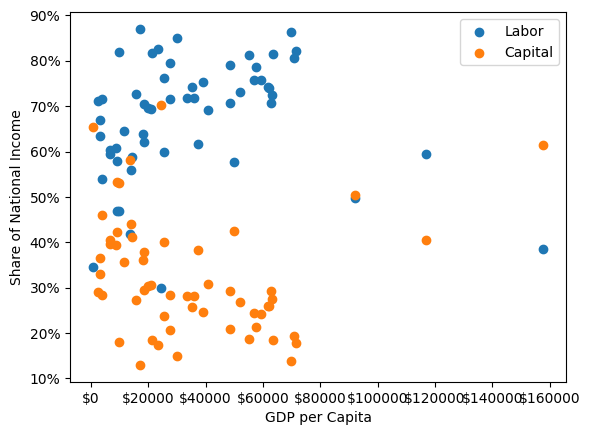

(PearsonRResult(statistic=0.08736790706584616, pvalue=0.5181257087411353),
 PearsonRResult(statistic=-0.08736789339544075, pvalue=0.5181257744680754))

In [12]:
plt.scatter(data['GDP per Capita'], data['Labor Share of National Income'])
plt.scatter(data['GDP per Capita'], data['Capital Share of National Income'])
plt.xlabel('GDP per Capita')
plt.ylabel('Share of National Income')
plt.legend(['Labor', 'Capital'])
plt.gca().xaxis.set_major_formatter('${x:1.0f}')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
stats.pearsonr(data['GDP per Capita'], data['Labor Share of National Income']), stats.pearsonr(data['GDP per Capita'], data['Capital Share of National Income'])

There is a positive correlation between GDP and social security benefits.

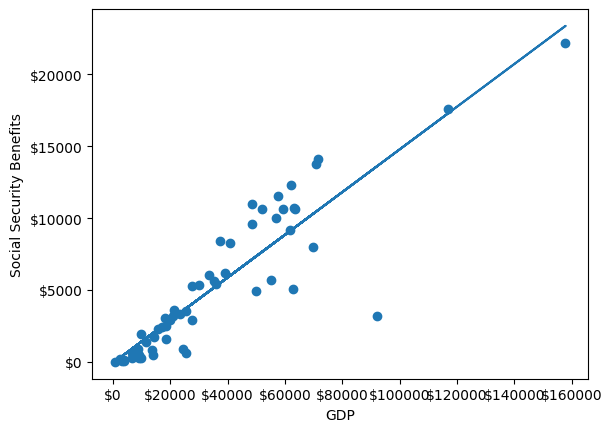

PearsonRResult(statistic=0.897302978082298, pvalue=3.480326750417275e-21)

In [13]:
plt.scatter(data['GDP per Capita'], data['Social Security Benefits'])
reg_m, reg_b = np.polyfit(data['GDP per Capita'], data['Social Security Benefits'], deg=1)
plt.plot(data['GDP per Capita'], reg_m * data['GDP per Capita'] + reg_b)
plt.xlabel('GDP')
plt.gca().xaxis.set_major_formatter('${x:1.0f}')
plt.ylabel('Social Security Benefits')
plt.gca().yaxis.set_major_formatter('${x:1.0f}')
plt.show()
stats.pearsonr(data['GDP per Capita'], data['Social Security Benefits'])

There is a correlation between average household wealth and GDP.

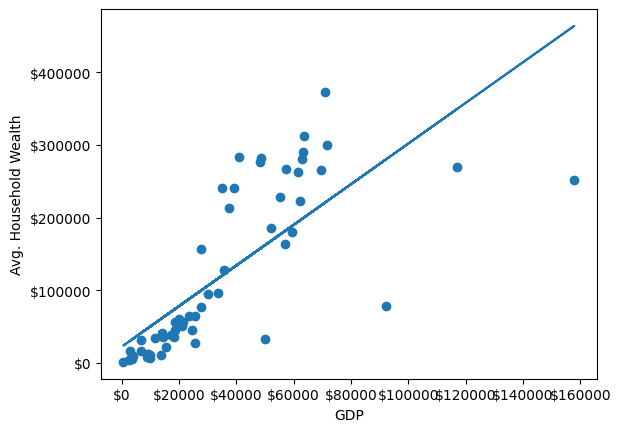

PearsonRResult(statistic=0.7541650443775278, pvalue=1.2628532472864478e-11)

In [14]:
plt.scatter(data['GDP per Capita'], data['Avg. Household Wealth'])
reg_m, reg_b = np.polyfit(data['GDP per Capita'], data['Avg. Household Wealth'], deg=1)
plt.plot(data['GDP per Capita'], reg_m * data['GDP per Capita'] + reg_b)
plt.xlabel('GDP')
plt.ylabel('Avg. Household Wealth')
plt.gca().xaxis.set_major_formatter('${x:1.0f}')
plt.gca().yaxis.set_major_formatter('${x:1.0f}')
plt.show()
stats.pearsonr(data['GDP per Capita'], data['Avg. Household Wealth'])

Interestingly, this correlation is stronger for the top 1% of household wealth.

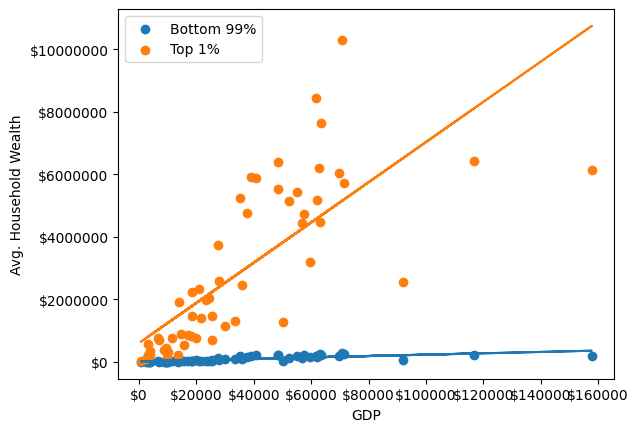

(PearsonRResult(statistic=0.7432229651716915, pvalue=3.570180192234571e-11),
 PearsonRResult(statistic=0.7528097276502693, pvalue=1.4405234698504927e-11))

In [15]:
plt.scatter(data['GDP per Capita'], data['Avg. Household Wealth (Bottom 99%)'])
plt.scatter(data['GDP per Capita'], data['Avg. Household Wealth (Top 1%)'])
reg_m, reg_b = np.polyfit(data['GDP per Capita'], data['Avg. Household Wealth (Bottom 99%)'], deg=1)
plt.plot(data['GDP per Capita'], reg_m * data['GDP per Capita'] + reg_b)
reg_m, reg_b = np.polyfit(data['GDP per Capita'], data['Avg. Household Wealth (Top 1%)'], deg=1)
plt.plot(data['GDP per Capita'], reg_m * data['GDP per Capita'] + reg_b)
plt.legend(['Bottom 99%', 'Top 1%'])
plt.xlabel('GDP')
plt.ylabel('Avg. Household Wealth')
plt.gca().xaxis.set_major_formatter('${x:1.0f}')
plt.gca().yaxis.set_major_formatter('${x:1.0f}')
plt.show()
stats.pearsonr(data['GDP per Capita'], data['Avg. Household Wealth (Bottom 99%)']), stats.pearsonr(data['GDP per Capita'], data['Avg. Household Wealth (Top 1%)'])

The correlation is still present, but much weaker, for the bottom 99% of households. Notice the scale of the y-axis has changed tremendously.

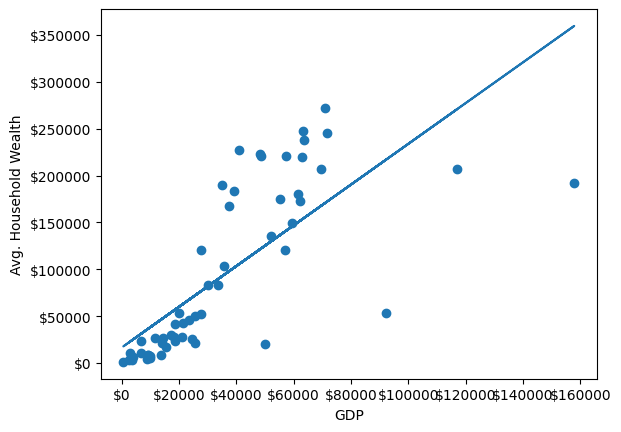

In [16]:
plt.scatter(data['GDP per Capita'], data['Avg. Household Wealth (Bottom 99%)'])
reg_m, reg_b = np.polyfit(data['GDP per Capita'], data['Avg. Household Wealth (Bottom 99%)'], deg=1)
plt.plot(data['GDP per Capita'], reg_m * data['GDP per Capita'] + reg_b)
plt.xlabel('GDP')
plt.ylabel('Avg. Household Wealth')
plt.gca().xaxis.set_major_formatter('${x:1.0f}')
plt.gca().yaxis.set_major_formatter('${x:1.0f}')
plt.show()